In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.utils.data as data_utils
from torch.utils.data.dataset import Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils import data
import pandas as pd
from PIL import Image
import os
import torchvision
import numpy as np
from torch.autograd import variable

In [2]:
pip install torch===1.6.0 torchvision===0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: numpy in c:\users\negar\appdata\local\programs\python\python38\lib\site-packages (from torch===1.6.0) (1.18.5)



You should consider upgrading via the 'c:\users\negar\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [3]:
transform=transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomRotation(5), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data = torchvision.datasets.FashionMNIST(root = "./data", train = True, download = True, transform = transforms.ToTensor())
test_data = torchvision.datasets.FashionMNIST(root = "./data", train = False, download = True, transform = transforms.ToTensor())

batch_size = 150

train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw


Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw
Processing...


c:\users\negar\appdata\local\programs\python\python38\lib\site-packages\torchvision\datasets\mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


# Model with L1 Regularization

In [4]:
class FashionMNIST(Dataset):
    def __init__(self, path, transform=None):
        self.transform = transform
        df = pd.read_csv(path)
        self.labels = df.label.values
        self.images = df.iloc[:, 1:].values.astype("uint8").reshape(-1, 28, 28)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        y = self.labels[idx]
        X = Image.fromarray(self.images[idx])
        
        if self.transform:
            X = self.transform(X)

        return X, y

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_block = nn.Sequential(nn.Conv2d(1, 128, 3, 1, 1),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2, 2),
                                   nn.Conv2d(128, 256, 3, 1, 1),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2, 2))

        self.clf = nn.Sequential(nn.Linear(7 * 7 * 256, 1024),
                                  nn.ReLU(),
                                  nn.Linear(1024, 10),
                                  nn.Softmax(dim=1))

    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(-1, 7 * 7 * 256)
        return self.clf(x)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = Net()

model.to(device)
print(model)

#define loss
criterion = nn.CrossEntropyLoss()

#define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

cpu
Net(
  (conv_block): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (clf): Sequential(
    (0): Linear(in_features=12544, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=10, bias=True)
    (3): Softmax(dim=1)
  )
)


In [8]:
LAMBDA = 0.009

acc_hist_train = []
acc_hist_test = []
n_epochs = 15

for epoch in range(n_epochs):
    #set train mode
    model.train() 
    acc_train = []
    acc_test = []
        
    for X,y in train_loader:
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        out = model(X)
        
        pred = out.detach().cpu().numpy()
        label = y.detach().cpu().numpy()
        a = (pred.argmax(axis=1) == label)
        acc_train.extend(a)
        
        loss = criterion(out, y)
        
         
        l1_regularization = torch.tensor(0).long()
        for param in model.parameters():
            l1_regularization += torch.norm(param, 1).long()
            
        loss += LAMBDA * l1_regularization
        
        
        loss.backward()
        optimizer.step()
        
      
    print("Training Accuracy for {}: {}%".format(epoch+1, sum(acc_train) / len(acc_train) * 100))
    acc_hist_train.append(sum(acc_train) / len(acc_train))
        
    model.eval()
    
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device)
            out = model(X)
            
            pred = out.detach().cpu().numpy()
            label = y.detach().cpu().numpy()
            a = (pred.argmax(axis=1) == label)
            acc_test.extend(a)
            
            loss = criterion(out, y)
            
        print("Validation Accuracy for {}: {}%".format(epoch+1, sum(acc_test) / len(acc_test) * 100))
        acc_hist_test.append(sum(acc_test) / len(acc_test))

Training Accuracy for 1: 61.916666666666664%
Validation Accuracy for 1: 74.99%
Training Accuracy for 2: 79.27333333333333%
Validation Accuracy for 2: 80.04%
Training Accuracy for 3: 82.40333333333332%
Validation Accuracy for 3: 86.83999999999999%
Training Accuracy for 4: 88.48666666666666%
Validation Accuracy for 4: 88.39%
Training Accuracy for 5: 90.17833333333334%
Validation Accuracy for 5: 89.57000000000001%
Training Accuracy for 6: 90.77499999999999%
Validation Accuracy for 6: 89.63%
Training Accuracy for 7: 91.56833333333333%
Validation Accuracy for 7: 90.35%
Training Accuracy for 8: 92.07666666666667%
Validation Accuracy for 8: 90.55%
Training Accuracy for 9: 92.67333333333333%
Validation Accuracy for 9: 90.74%
Training Accuracy for 10: 92.99833333333333%
Validation Accuracy for 10: 90.32%
Training Accuracy for 11: 93.51666666666667%
Validation Accuracy for 11: 90.86999999999999%
Training Accuracy for 12: 93.72666666666667%
Validation Accuracy for 12: 90.86%
Training Accuracy for

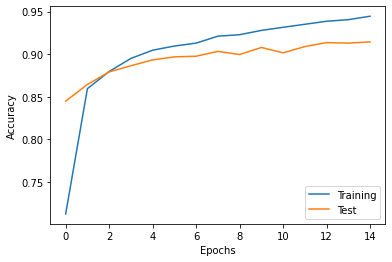

In [9]:
plt.plot(acc_hist_train, label="Training")
plt.plot(acc_hist_test, label="Test")
plt.legend(loc="lower right")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

# L2 Regularization

In [9]:
LAMBDA = 0.009

acc_hist_train = []
acc_hist_test = []
n_epochs = 15

for epoch in range(n_epochs):
    #set train mode
    model.train() 
    acc_train = []
    acc_test = []
        
    for X,y in train_loader:
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        out = model(X)
        
        pred = out.detach().cpu().numpy()
        label = y.detach().cpu().numpy()
        a = (pred.argmax(axis=1) == label)
        acc_train.extend(a)
        
        loss = criterion(out, y)
        
         
        l2_regularization = torch.tensor(0).long()
        for param in model.parameters():
            l2_regularization += torch.norm(param, 1).long()
            
        loss += LAMBDA * l2_regularization
        
        
        loss.backward()
        optimizer.step()
        
      
    print("Training Accuracy for {}: {}%".format(epoch+1, sum(acc_train) / len(acc_train) * 100))
    acc_hist_train.append(sum(acc_train) / len(acc_train))
        
    model.eval()
    
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device)
            out = model(X)
            
            pred = out.detach().cpu().numpy()
            label = y.detach().cpu().numpy()
            a = (pred.argmax(axis=1) == label)
            acc_test.extend(a)
            
            loss = criterion(out, y)
            
        print("Validation Accuracy for {}: {}%".format(epoch+1, sum(acc_test) / len(acc_test) * 100))
        acc_hist_test.append(sum(acc_test) / len(acc_test))

Training Accuracy for 1: 94.96%
Validation Accuracy for 1: 91.53%
Training Accuracy for 2: 95.19833333333332%
Validation Accuracy for 2: 91.22%
Training Accuracy for 3: 95.475%
Validation Accuracy for 3: 91.82000000000001%
Training Accuracy for 4: 95.58166666666666%
Validation Accuracy for 4: 91.74%
Training Accuracy for 5: 95.84333333333333%
Validation Accuracy for 5: 91.55%
Training Accuracy for 6: 95.84333333333333%
Validation Accuracy for 6: 91.94%
Training Accuracy for 7: 96.06333333333333%
Validation Accuracy for 7: 91.91%
Training Accuracy for 8: 96.08666666666666%
Validation Accuracy for 8: 91.78%
Training Accuracy for 9: 96.27%
Validation Accuracy for 9: 91.91%
Training Accuracy for 10: 96.295%
Validation Accuracy for 10: 91.75999999999999%
Training Accuracy for 11: 96.51166666666666%
Validation Accuracy for 11: 92.08%
Training Accuracy for 12: 96.69166666666666%
Validation Accuracy for 12: 91.83%
Training Accuracy for 13: 96.72333333333333%
Validation Accuracy for 13: 92.06%


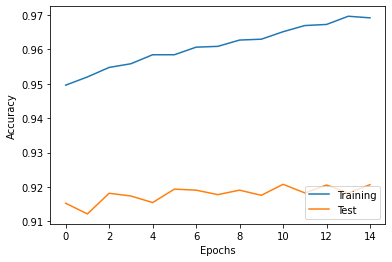

In [10]:
plt.plot(acc_hist_train, label="Training")
plt.plot(acc_hist_test, label="Test")
plt.legend(loc="lower right")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()